✅ Training Data Shape: (4920, 134)
✅ Testing Data Shape: (42, 133)
✅ Data cleaned, aligned, and scaled successfully!

✅ All models trained successfully!


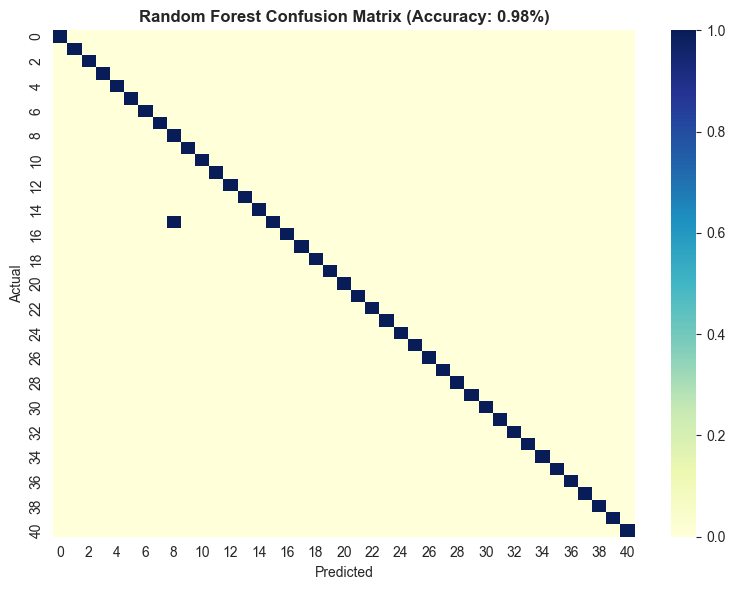

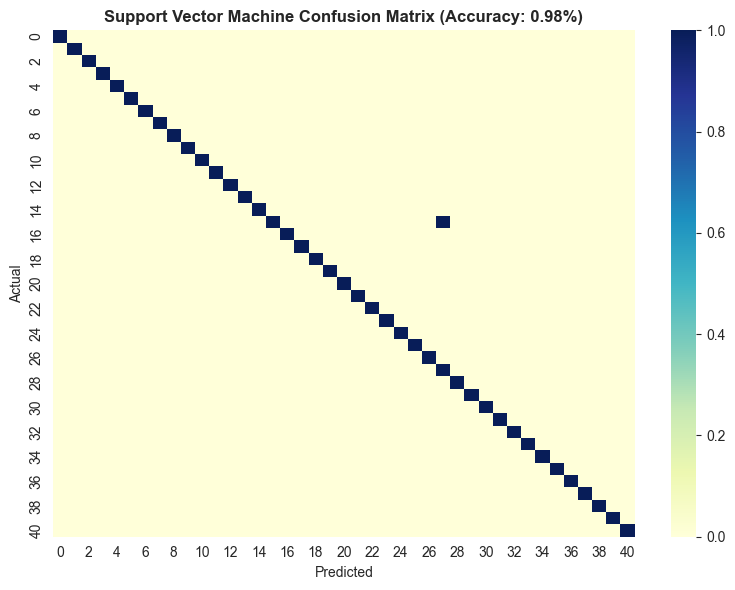

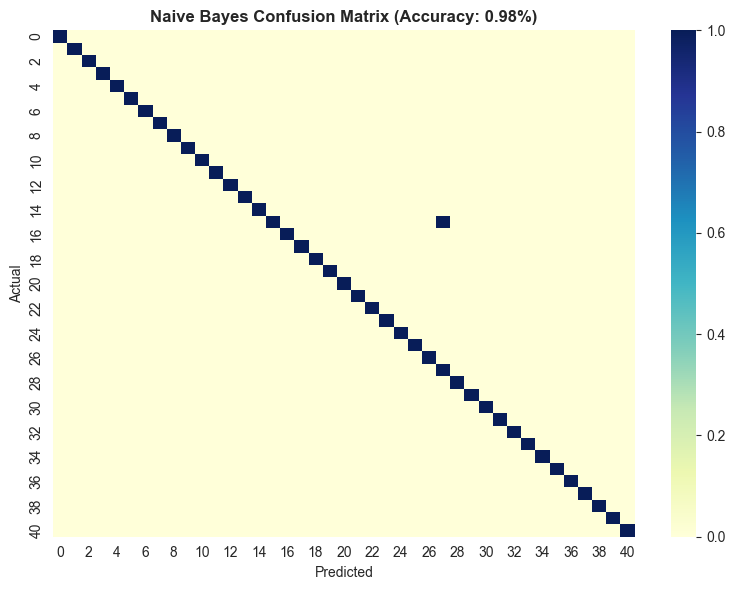

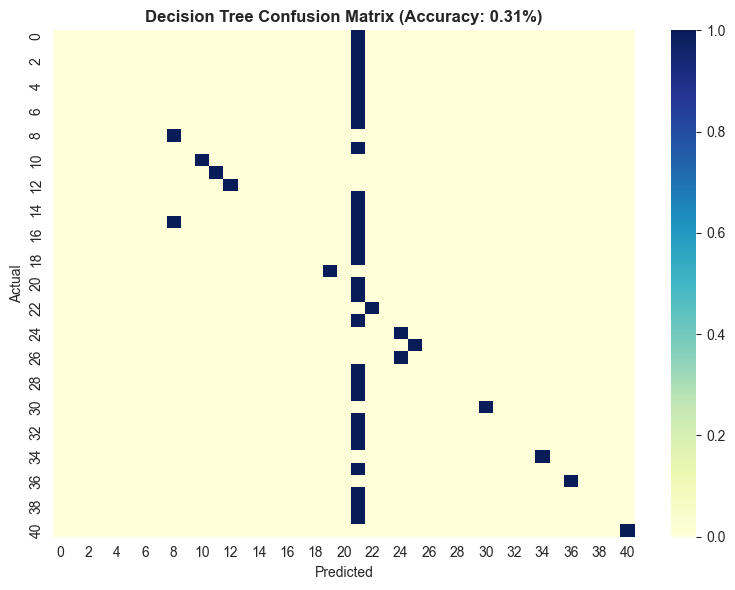

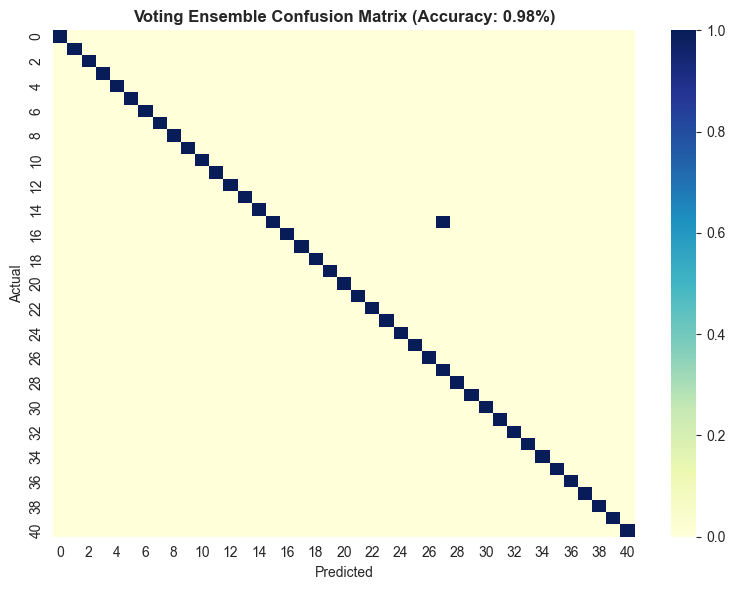


📊 Model Accuracies:
Random Forest: 97.62%
Support Vector Machine: 97.62%
Naive Bayes: 97.62%
Decision Tree: 30.95%
Voting Ensemble: 97.62%

🧠 Final Voting Ensemble Test Accuracy: 97.62 %

Classification Report:
                                          precision    recall  f1-score   support

(vertigo) Paroymsal  Positional Vertigo       1.00      1.00      1.00         1
                                   AIDS       1.00      1.00      1.00         1
                                   Acne       1.00      1.00      1.00         1
                    Alcoholic hepatitis       1.00      1.00      1.00         1
                                Allergy       1.00      1.00      1.00         1
                              Arthritis       1.00      1.00      1.00         1
                       Bronchial Asthma       1.00      1.00      1.00         1
                   Cervical spondylosis       1.00      1.00      1.00         1
                            Chicken pox       1.00      1

In [22]:
# ===============================================================
# DISEASE PREDICTION USING MACHINE LEARNING (NO SMOTE VERSION)
# Authors: Ananya M D & Ananya G Devadiga
# ===============================================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# ---------------------------------------------------------------
# 1️⃣ Load and Clean Dataset
# ---------------------------------------------------------------
train_data = pd.read_csv('data/Training.csv')
test_data = pd.read_csv('data/Testing.csv')

print("✅ Training Data Shape:", train_data.shape)
print("✅ Testing Data Shape:", test_data.shape)

# Replace blanks or NaNs with 0
train_data = train_data.replace(' ', np.nan).fillna(0)
test_data = test_data.replace(' ', np.nan).fillna(0)

# Drop duplicates if any
train_data = train_data.drop_duplicates()
test_data = test_data.drop_duplicates()

# ---------------------------------------------------------------
# 2️⃣ Split Features and Target
# ---------------------------------------------------------------
X_train_full = train_data.drop(columns=['prognosis'])
y_train_full = train_data['prognosis']

X_test_full = test_data.drop(columns=['prognosis'])
y_test_full = test_data['prognosis']

# ---------------------------------------------------------------
# 3️⃣ Convert to Numeric and Align Columns
# ---------------------------------------------------------------
# Convert all columns to numeric safely
X_train_full = X_train_full.apply(pd.to_numeric, errors='coerce').fillna(0)
X_test_full = X_test_full.apply(pd.to_numeric, errors='coerce').fillna(0)

# Align test data columns to match training columns
X_test_full = X_test_full.reindex(columns=X_train_full.columns, fill_value=0)

# ---------------------------------------------------------------
# 4️⃣ Encode Target
# ---------------------------------------------------------------
encoder = LabelEncoder()
y_train_encoded = encoder.fit_transform(y_train_full)
y_test_encoded = encoder.transform(y_test_full)

# ---------------------------------------------------------------
# 5️⃣ Scale Features
# ---------------------------------------------------------------
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_full)
X_test_scaled = scaler.transform(X_test_full)

# Verify no NaNs remain
assert not np.isnan(X_train_scaled).any(), "NaNs in training data!"
assert not np.isnan(X_test_scaled).any(), "NaNs in test data!"

print("✅ Data cleaned, aligned, and scaled successfully!")

# ---------------------------------------------------------------
# 6️⃣ Train Models
# ---------------------------------------------------------------
rf_model = RandomForestClassifier(n_estimators=200, max_depth=20, random_state=42)
svm_model = SVC(kernel='rbf', C=3, gamma='scale', probability=True, random_state=42)
nb_model = GaussianNB()
dt_model = DecisionTreeClassifier(max_depth=12, random_state=42)

rf_model.fit(X_train_full, y_train_encoded)
svm_model.fit(X_train_scaled, y_train_encoded)
nb_model.fit(X_train_scaled, y_train_encoded)
dt_model.fit(X_train_full, y_train_encoded)

# Hybrid Ensemble (Voting Classifier)
voting_model = VotingClassifier(
    estimators=[('rf', rf_model), ('svm', svm_model), ('nb', nb_model)],
    voting='soft',
    weights=[3, 2, 1]
)
voting_model.fit(X_train_scaled, y_train_encoded)
print("\n✅ All models trained successfully!")

# ---------------------------------------------------------------
# 7️⃣ Evaluate Models
# ---------------------------------------------------------------
models = {
    "Random Forest": rf_model,
    "Support Vector Machine": svm_model,
    "Naive Bayes": nb_model,
    "Decision Tree": dt_model,
    "Voting Ensemble": voting_model
}

accuracies = {}
sns.set_style("whitegrid")

for name, model in models.items():
    X_input = X_test_scaled if name in ["Support Vector Machine", "Naive Bayes", "Voting Ensemble"] else X_test_full
    y_pred = model.predict(X_input)
    acc = accuracy_score(y_test_encoded, y_pred)
    accuracies[name] = round(acc * 100, 2)

    cm = confusion_matrix(y_test_encoded, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, cmap="YlGnBu", cbar=True)
    plt.title(f"{name} Confusion Matrix (Accuracy: {acc:.2f}%)", fontsize=12, weight='bold')
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.tight_layout()
    plt.show()

print("\n📊 Model Accuracies:")
for name, acc in accuracies.items():
    print(f"{name}: {acc}%")

# ---------------------------------------------------------------
# 8️⃣ Final Test Evaluation (Voting Ensemble)
# ---------------------------------------------------------------
y_pred_test = voting_model.predict(X_test_scaled)
final_acc = accuracy_score(y_test_encoded, y_pred_test)
print("\n🧠 Final Voting Ensemble Test Accuracy:", round(final_acc * 100, 2), "%")
print("\nClassification Report:\n", classification_report(y_test_encoded, y_pred_test, target_names=encoder.classes_))

# ---------------------------------------------------------------
# 9️⃣ Save Final Model
# ---------------------------------------------------------------
symptoms = X_train_full.columns.values
symptom_index = {symptom: idx for idx, symptom in enumerate(symptoms)}

model_data = {
    "rf_model": rf_model,
    "svm_model": svm_model,
    "nb_model": nb_model,
    "dt_model": dt_model,
    "voting_model": voting_model,
    "encoder": encoder,
    "scaler": scaler,
    "symptom_index": symptom_index
}

with open("model.pkl", "wb") as file:
    pickle.dump(model_data, file)

print("\n✅ model.pkl saved successfully!")
